<a href="https://colab.research.google.com/github/musman2012/ml-data_science/blob/master/SOH_Prediction/Phase_II_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Phase-II
This phase would have the following keys steps to perform:
* Apply labelling/binning on the data (yet to decided the technique)
* Make three clusters/subsets of the data on the basis of cycle variable
* Apply Association Rule Mining on the subsets
* Apply prediction technique to classify the target variable soh
* Evaluate Models Results

More explanation for the process and what I want to acheive 

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import platform
import dill
dill.load_session('phase-II-ml.db')

In [2]:
'''
authored by Muhammad Usman (musman14@student.bradford.ac.uk)

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

FILE_PATH = "batteries_processed.csv"
bat_data = pd.read_csv(FILE_PATH, error_bad_lines = False)    # reading the data from csv file

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Removing the same features which were removed in Phase-I as well

In [6]:
filtered_data = bat_data.copy()
columns_to_drop = ['id', 'vin', 'vin_prefix', 'record_id','recorded_time', 'actual_time', 'arrival_time', 'powermode', 'mheader_vin', 'mheader_time', 'mheader_type', 'message','cat4', 'cat6', 'cat7', 'inlet_coolant_temp','cooling_energy_used', 'max_soh_cell', 'power_soh', 'min_soh', 'max_soh', 'min_soh_cell_id','imbalance_percent', 'parkingdata_hvbattavgsocoatevent', 'parkingdata_hvbattavtempatevent']
filtered_data = filtered_data.drop(columns=columns_to_drop)
filtered_data.head()

,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,fuse_temp,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance
0,10619,6.5,0.0,22,noBalancing,4.107,12,0.675,4.153,0.046,445,15,22,96,14,1,870,135,activeHeating,195,98.0,0,storage,1,False,0
1,9531,4.0,0.0,22,noBalancing,3.983,6,7.375,4.008,0.025,432,16,36,21,7,1,870,90,idle,55,98.0,0,storage,1,False,-1088
2,9531,4.0,0.0,22,noBalancing,3.989,6,7.600,4.023,0.034,431,16,36,76,7,1,870,90,idle,55,98.0,0,storage,1,False,0
3,9531,4.0,0.0,22,noBalancing,3.984,6,6.850,4.020,0.036,431,16,36,79,7,1,870,90,idle,55,98.0,0,storage,1,False,0
4,9531,4.0,0.0,22,noBalancing,3.980,6,7.000,4.015,0.035,431,16,36,85,7,1,870,90,idle,55,98.0,0,storage,1,False,0


In [5]:
print(filtered_data.nunique() > 4)

odometer                   True
ambient_temp               True
vehicle_speed              True
balancing_trigger_cell     True
balancing_status          False
min_voltage                True
min_temp                   True
traction_current           True
max_voltage                True
imbalance                  True
traction_voltage           True
min_temp_cell              True
min_voltage_cell           True
max_voltage_cell           True
max_temp                   True
max_temp_cell              True
fuse_temp                 False
emodule_temp               True
thermal_manager_mode       True
outlet_coolant_temp        True
soh                        True
fast_charge_count          True
cycle                     False
num_cycle                  True
fast_charge               False
trip_distance              True
dtype: bool


### Binning the data
We have to choices for Binning the data here:
* Fixed-Width Binning: Specific fixed widths for each of the bins which are usually pre-defined
* Adaptive Binning: Such binning in which we use the data distribution itself to decide bin ranges

&rightarrow; Quantile Binning is one of the type of Adaptive Binning which helps in partitioning the continuous valued distribution of a specific numeric field into discrete contiguous bins or intervals. We will use this binning to convert out continuous variables into categorical variables.

In [7]:
int_cols = filtered_data.select_dtypes('int64') ## finding all the continuous variables
float_cols = filtered_data.select_dtypes('float')
categ_data = pd.DataFrame()
int_cols = int_cols.loc[:, int_cols.nunique() > 4]
float_cols = float_cols.loc[:, float_cols.nunique() > 4]

quantiles = [.0,.25,.5,.75,1.]
boundaries = dict()
for col in int_cols.columns:
  print("Col in progress is ", col)
  col_labels=[col+"_Low", col+"_Medium", col+"_High", col+"_Very_High"]
  filtered_data[col], boundaries[col] = pd.qcut(filtered_data[col], 4,duplicates='drop', labels=False, retbins=True)
for col in float_cols.columns:
  col_labels=[col+"_Low", col+"_Medium", col+"_High", col+"_Very_High"]
  filtered_data[col], boundaries[col] = pd.qcut(filtered_data[col], 4, duplicates='drop', labels=False, retbins=True)
filtered_data.head()

Col in progress is  odometer
Col in progress is  balancing_trigger_cell
Col in progress is  min_temp
Col in progress is  traction_voltage
Col in progress is  min_temp_cell
Col in progress is  min_voltage_cell
Col in progress is  max_voltage_cell
Col in progress is  max_temp
Col in progress is  max_temp_cell
Col in progress is  emodule_temp
Col in progress is  outlet_coolant_temp
Col in progress is  fast_charge_count
Col in progress is  num_cycle
Col in progress is  trip_distance


,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,fuse_temp,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance
0,3,1,0,0,noBalancing,3,1,3,3,3,3,1,0,3,1,0,870,0,activeHeating,3,0,0,storage,0,False,0
1,3,0,0,0,noBalancing,2,0,3,2,2,2,1,1,1,0,0,870,0,idle,0,0,0,storage,0,False,0
2,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,870,0,idle,0,0,0,storage,0,False,0
3,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,870,0,idle,0,0,0,storage,0,False,0
4,3,0,0,0,noBalancing,2,0,3,2,3,2,1,1,3,0,0,870,0,idle,0,0,0,storage,0,False,0


In [0]:
def variable_to_bin(var, df_train):
    
    # Lets calculate bin values for a particular column in the dataframe passed to this function
    bin_values = stats.bayesian_blocks(filtered_data[var],
                                      fitness='events',
                                      p0=0.01)
    
    # Lets create labels for bin values so as to use these labels in dataframe 
    labels = []
    for i, x in enumerate(bin_values):
        labels.append(i)
    
    # delete the last bin label 
    del labels[-1]

    # create a new dataframe to 
    df = pd.DataFrame(index=filtered_data.index)

    df["ID_code"] = df_train["ID_code"]
    df['new' + var] = pd.cut(df_train[var], 
                               bins = bin_values, 
                               labels = labels)
    
    df.set_index('ID_code')
    
    # Lets delete the bin values and labels to some some space.
    del bin_values, labels

def get_new_feature_train():
    int_cols = filtered_data.select_dtypes('int64')
    features = [c for c in int_cols.columns]

    # Use below line to test whether the binning works or not. 
    #features = ('var_2', 'var_3')
    
    new_df = pd.DataFrame()
    
    # Lets create a multi processing pool but N - 4 CPU's = 4 less CPU's then what your machine has.
    # My machine has 16 CPU's, but I wanted to use 12 of them for calculating bins. 
    pool = mp.Pool(mp.cpu_count() - 4)
    
    # Lets map each CPU to each variable coming out of features list. This line helps in parallel computation
    # of bayesian block bins. 
    results = pool.map(variable_to_bin, features)
    
    pool.close()
    pool.join()
    
    # Lets reduce the series coming out of variable_to_bin function and create a new dataframe.
    results_df = reduce(lambda x, y: pd.merge(x, y, on = 'ID_code'), results)

    return results_df

In [10]:
d = {0 : 'Low', 1 : 'Medium', 2 : 'High', 3 : 'Very_High'}
for c in float_cols.columns:
  filtered_data[c] = filtered_data[c].map(d)
filtered_data.head()

,odometer,ambient_temp,vehicle_speed,balancing_trigger_cell,balancing_status,min_voltage,min_temp,traction_current,max_voltage,imbalance,traction_voltage,min_temp_cell,min_voltage_cell,max_voltage_cell,max_temp,max_temp_cell,fuse_temp,emodule_temp,thermal_manager_mode,outlet_coolant_temp,soh,fast_charge_count,cycle,num_cycle,fast_charge,trip_distance
0,Very_High,Medium,Low,Low,noBalancing,Very_High,Medium,Very_High,Very_High,Very_High,Very_High,Medium,Low,Very_High,Medium,Low,870,Low,activeHeating,Very_High,Low,Low,storage,Low,False,Low
1,Very_High,Low,Low,Low,noBalancing,High,Low,Very_High,High,High,High,Medium,Medium,Medium,Low,Low,870,Low,idle,Low,Low,Low,storage,Low,False,Low
2,Very_High,Low,Low,Low,noBalancing,High,Low,Very_High,High,Very_High,High,Medium,Medium,Very_High,Low,Low,870,Low,idle,Low,Low,Low,storage,Low,False,Low
3,Very_High,Low,Low,Low,noBalancing,High,Low,Very_High,High,Very_High,High,Medium,Medium,Very_High,Low,Low,870,Low,idle,Low,Low,Low,storage,Low,False,Low
4,Very_High,Low,Low,Low,noBalancing,High,Low,Very_High,High,Very_High,High,Medium,Medium,Very_High,Low,Low,870,Low,idle,Low,Low,Low,storage,Low,False,Low


In [5]:
for c in filtered_data.columns:
  print("Column", c)
  print(filtered_data[c].value_counts(normalize='true'))

Column odometer
0    0.250068
1    0.250000
3    0.249968
2    0.249964
Name: odometer, dtype: float64
Column ambient_temp
0    0.270383
2    0.247501
3    0.241288
1    0.240828
Name: ambient_temp, dtype: float64
Column vehicle_speed
0    1.0
Name: vehicle_speed, dtype: float64
Column balancing_trigger_cell
2    0.256329
0    0.252668
1    0.248518
3    0.242485
Name: balancing_trigger_cell, dtype: float64
Column balancing_status
noBalancing         0.714526
passiveBalancing    0.285253
initialValue        0.000221
Name: balancing_status, dtype: float64
Column min_voltage
0    0.250488
1    0.250466
2    0.249558
3    0.249488
Name: min_voltage, dtype: float64
Column min_temp
0    0.317571
1    0.229993
3    0.228385
2    0.224050
Name: min_temp, dtype: float64
Column traction_current
0    0.250455
3    0.249992
2    0.249890
1    0.249662
Name: traction_current, dtype: float64
Column max_voltage
0    0.251233
2    0.249916
1    0.249685
3    0.249167
Name: max_voltage, dtype: float64

### Creating subsets of the data on the basis of cycle variable

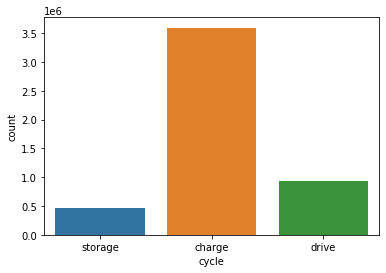

In [0]:
sns.countplot(filtered_data['cycle'])

In [11]:
bat_storage_data = filtered_data[bat_data['cycle'] == 'storage']
bat_charge_data = filtered_data[bat_data['cycle'] == 'charge']
bat_drive_data = filtered_data[bat_data['cycle'] == 'drive']
print("storage data dimensions are ", bat_storage_data.shape)
print("charge data dimensions are ", bat_charge_data.shape)
print("drive data dimensions are ", bat_drive_data.shape)

storage data dimensions are  (467495, 26)
charge data dimensions are  (3595456, 26)
drive data dimensions are  (937049, 26)


In [0]:
from mlxtend.frequent_patterns import apriori, association_rules

In [13]:
arm = apriori(bat_storage_data, min_support = 0.04, use_colnames = True) 

assoc_rules = association_rules(arm, metric ="confidence", min_threshold = 0.8) 
assoc_rules = assoc_rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 

TypeError: ignored

In [0]:
import dill
dill.dump_session('phase-II-ml.db')